## 1. Import packages and data

In [2]:
###Loading Packages###
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions

import re # regular expressions
import os # Operation System
from datetime import datetime

import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import sys

import time
import math
from pprint import pprint

import matplotlib.pyplot as plt

import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string

import warnings
warnings.filterwarnings("ignore")

from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import matplotlib.cm as cm

In [3]:
import time
from timeit import default_timer as timer
from datetime import timedelta

In [6]:
cleaned_df = pd.read_pickle('cleaned_data.pkl')

## 3. Extract Topic - LDA

### 3.1 Text cleaning & preprocessing

In [1]:
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pickle

In [8]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 7 workers


In [9]:
# helper method to record the time
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

#### Tokenize text into words and remove punctuation

In [10]:
#%%time
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [26]:
%%time
data_list = cleaned_df['text'].tolist()        
data_tokens = list(sent_to_words(data_list))

Wall time: 14min 3s


In [28]:
pickle.dump(data_tokens, open('tokenized_text.pkl', 'wb'))

In [ ]:
data_tokens = pickle.load(open('tokenized_text.pkl', 'rb'))

#### Remove Stopwords, Make n-grams and Lemmatize

In [29]:
%%time

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Wall time: 23min 46s


In [30]:
#%%time
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [31]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(*data_lemmatized[:1])

Wall time: 1h 40min 35s


In [32]:
pickle.dump(data_lemmatized, open('lemmatized_text.pkl', 'wb'))

In [5]:
data_lemmatized = pickle.load(open('lemmatized_text.pkl', 'rb'))

In [6]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

Wall time: 2min 20s


### 3.2 Build and tune LDA models

#### Tune LDA model

In [13]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, 
                                         dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [24]:
%%time

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=3,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

Wall time: 12min 47s


In [25]:
# Print the Keyword in the 3 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]

[(0,
  '0.009*"also" + 0.008*"well" + 0.004*"company" + 0.004*"work" + 0.003*"mom" '
  '+ 0.003*"need" + 0.003*"get" + 0.003*"state" + 0.003*"tdi" + 0.003*"make"'),
 (1,
  '0.011*"say" + 0.006*"go" + 0.005*"get" + 0.004*"make" + 0.004*"game" + '
  '0.004*"see" + 0.004*"year" + 0.004*"time" + 0.003*"team" + 0.003*"state"'),
 (2,
  '0.007*"also" + 0.007*"well" + 0.006*"use" + 0.005*"get" + 0.005*"time" + '
  '0.005*"need" + 0.003*"make" + 0.003*"go" + 0.003*"work" + '
  '0.003*"sweepstake"')]


#### Compute Coherence Score

In [26]:
%%time

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3299187712581748
Wall time: 2min 10s


#### Hyperparameter Tuning:
- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

### 10-15 topics

In [27]:
%%time

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 10
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()

LDA will execute 6 iterations
Completed model based on 10 LDA topics. Finished 16.7% of LDA runs
Execution time to calculate for topic 10: 0hour:20min:43sec
Completed model based on 11 LDA topics. Finished 33.3% of LDA runs
Execution time to calculate for topic 11: 0hour:21min:20sec
Completed model based on 12 LDA topics. Finished 50.0% of LDA runs
Execution time to calculate for topic 12: 0hour:21min:56sec
Completed model based on 13 LDA topics. Finished 66.7% of LDA runs
Execution time to calculate for topic 13: 0hour:22min:46sec
Completed model based on 14 LDA topics. Finished 83.3% of LDA runs
Execution time to calculate for topic 14: 0hour:31min:3sec
Completed model based on 15 LDA topics. Finished 100.0% of LDA runs
Execution time to calculate for topic 15: 0hour:27min:16sec
Wall time: 2h 25min 3s


In [28]:
lda_tuning = pd.DataFrame(model_results)

In [29]:
# Best LDA parameters
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
3,13,asymmetric,auto,0.511738
4,14,asymmetric,auto,0.504834
1,11,asymmetric,auto,0.502225
2,12,asymmetric,auto,0.501802
5,15,asymmetric,auto,0.501142
0,10,asymmetric,auto,0.491126


<AxesSubplot:xlabel='Topics'>

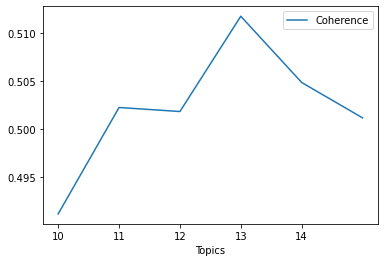

In [34]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(10,15))

In [35]:
lda_tuning.to_csv(os.path.join('lda_tuning_results.csv'), index=False)

In [36]:
lda_tuning.to_pickle("./lda_tuning.pkl")

In [14]:
lda_tuning = pd.read_pickle('lda_tuning.pkl')

### 16-19 topics

In [37]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 16
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
beta = ['auto'] # Run for number of topics only

# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [doc_term_matrix]
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()

LDA will execute 5 iterations
Completed model based on 16 LDA topics. Finished 20.0% of LDA runs
Execution time to calculate for topic 16: 0hour:25min:39sec
Completed model based on 17 LDA topics. Finished 40.0% of LDA runs
Execution time to calculate for topic 17: 0hour:27min:33sec
Completed model based on 18 LDA topics. Finished 60.0% of LDA runs
Execution time to calculate for topic 18: 0hour:27min:57sec
Completed model based on 19 LDA topics. Finished 80.0% of LDA runs
Execution time to calculate for topic 19: 0hour:29min:40sec


OSError: [Errno 22] Invalid argument

In [42]:
lda_tuning_16_19 = pd.DataFrame(model_results)

In [43]:
# Best LDA parameters
lda_tuning_16_19.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
2,18,asymmetric,auto,0.515411
3,19,asymmetric,auto,0.500278
1,17,asymmetric,auto,0.463183
0,16,asymmetric,auto,0.448947


<AxesSubplot:xlabel='Topics'>

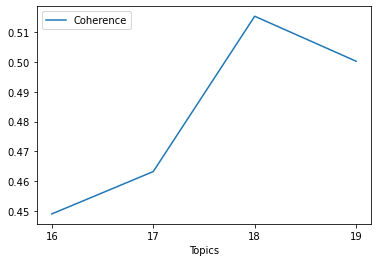

In [50]:
lda_tuning_16_19.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(16,20))

In [47]:
lda_tuning_16_19.to_csv(os.path.join('lda_tuning_results_16_19.csv'), index=False)

In [48]:
lda_tuning_16_19.to_pickle("./lda_tuning_16_19.pkl")

In [15]:
lda_tuning_16_19 = pd.read_pickle('lda_tuning_16_19.pkl')

### 20-21 topics

In [15]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 20
max_topics = 21
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
beta = ['auto'] # Run for number of topics only

# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [doc_term_matrix]
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()

LDA will execute 2 iterations
Completed model based on 20 LDA topics. Finished 50.0% of LDA runs
Execution time to calculate for topic 20: 0hour:23min:45sec
Completed model based on 21 LDA topics. Finished 100.0% of LDA runs
Execution time to calculate for topic 21: 0hour:24min:38sec
CPU times: user 33min 15s, sys: 21min 27s, total: 54min 42s
Wall time: 48min 23s


In [16]:
lda_tuning_20_21 = pd.DataFrame(model_results)

In [17]:
# Best LDA parameters
lda_tuning_20_21.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
1,21,asymmetric,auto,0.450092
0,20,asymmetric,auto,0.436051


In [18]:
lda_tuning_20_21.to_csv(os.path.join('lda_tuning_results_20_21.csv'), index=False)

In [19]:
lda_tuning_20_21.to_pickle("./lda_tuning_20_21.pkl")

In [17]:
lda_tuning_20_21 = pd.read_pickle('lda_tuning_20_21.pkl')

### Final result

In [36]:
frames = [lda_tuning, lda_tuning_16_19, lda_tuning_20_21]
final_lda_result = pd.concat(frames)

In [37]:
final_lda_result.to_csv(os.path.join('lda_tuning_final.csv'), index=False)

In [38]:
final_lda_result.to_pickle("./final_lda_result.pkl")

In [ ]:
final_lda_result = pd.read_pickle('final_lda_result.pkl')

<AxesSubplot:xlabel='Topics'>

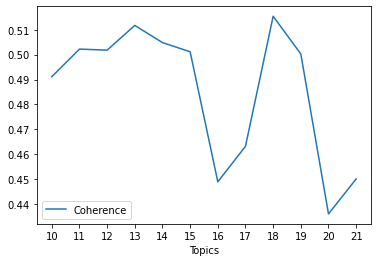

In [39]:
final_lda_result.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(10,22))

In [40]:
final_lda_result.sort_values(by=['Coherence'], ascending=False)

,Topics,Alpha,Beta,Coherence
2,18,asymmetric,auto,0.515411
3,13,asymmetric,auto,0.511738
4,14,asymmetric,auto,0.504834
1,11,asymmetric,auto,0.502225
2,12,asymmetric,auto,0.501802
5,15,asymmetric,auto,0.501142
3,19,asymmetric,auto,0.500278
0,10,asymmetric,auto,0.491126
1,17,asymmetric,auto,0.463183
1,21,asymmetric,auto,0.450092


### Visualization

In [7]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

C:\Users\60357\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


#### Final Model with lowest duplication - Topics: 16, Alpha: 0.61, Beta: symmetric (5th highest coherence)

In [31]:
#lda_tuning_best = lda_tuning_v2.sort_values(by=['Coherence'], ascending=False).head(1)
#lda_tuning_best = pd.DataFrame(final_lda_result.sort_values(by=['Coherence'], ascending=False).iloc[4]).T
lda_tuning_best = final_lda_result.sort_values(by=['Coherence'], ascending=False).head(1)
tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))

# Since the values for Alpha and Beta can be float, symmetric and asymmetric, 
# we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 18, Alpha: asymmetric, Beta: auto


C:\Users\60357\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())

C:\Users\60357\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.5167997082414972
Wall time: 28min 29s


In [33]:
# Print the Keyword in the 18 topics
pprint(tuned_lda_model.print_topics())

C:\Users\60357\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.010*"company" + 0.007*"work" + 0.007*"program" + 0.006*"include" + '
  '0.005*"provide" + 0.005*"business" + 0.005*"service" + 0.004*"support" + '
  '0.004*"team" + 0.004*"new"'),
 (1,
  '0.014*"say" + 0.007*"city" + 0.006*"accord" + 0.005*"year" + 0.004*"news" + '
  '0.004*"report" + 0.004*"area" + 0.004*"state" + 0.004*"expect" + '
  '0.003*"also"'),
 (2,
  '0.015*"also" + 0.014*"well" + 0.008*"alcohol" + 0.007*"individual" + '
  '0.006*"use" + 0.005*"time" + 0.005*"treatment" + 0.005*"person" + '
  '0.004*"content" + 0.004*"need"'),
 (3,
  '0.015*"game" + 0.012*"team" + 0.011*"season" + 0.010*"go" + 0.009*"get" + '
  '0.009*"play" + 0.008*"bear" + 0.006*"make" + 0.006*"say" + 0.005*"win"'),
 (4,
  '0.010*"get" + 0.006*"use" + 0.006*"need" + 0.005*"time" + 0.004*"also" + '
  '0.004*"find" + 0.004*"lawyer" + 0.004*"go" + 0.004*"company" + '
  '0.004*"work"'),
 (5,
  '0.019*"roof" + 0.007*"repair" + 0.006*"cookie" + 0.006*"set" + 0.006*"door" '
  '+ 0.005*"roofing" + 0.005*"u

In [34]:
pickle.dump(tuned_lda_model, open('tuned_lda_model.pkl', 'wb'))

C:\Users\60357\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
tuned_lda_model = pickle.load(open('tuned_lda_model.pkl', 'rb'))

In [8]:
%%time
warnings.filterwarnings("ignore", category=DeprecationWarning) 
lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

C:\Users\60357\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 5min 57s


In [53]:
topic_words = pd.DataFrame(columns=range(0,18))
topic_words.iloc[:,0]

Series([], Name: 0, dtype: object)

In [54]:
for i in range(18):
    print("Current topic:", i)
    top_words = tuned_lda_model.show_topic(i, topn=20)
    words = []
    for j in range(20):
        words.append(top_words[j][0])
        
    topic_words.iloc[:,i] = words

Current topic: 0
Current topic: 1
Current topic: 2
Current topic: 3
Current topic: 4
Current topic: 5
Current topic: 6
Current topic: 7
Current topic: 8
Current topic: 9
Current topic: 10
Current topic: 11
Current topic: 12
Current topic: 13
Current topic: 14
Current topic: 15
Current topic: 16
Current topic: 17


In [55]:
topic_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,company,say,also,game,get,roof,sweepstake,say,state,pizza,share,also,go,also,ad,mom,school,point
1,work,city,well,team,use,repair,sponsor,state,covid,well,stock,well,say,well,_,dad,student,shoot
2,program,accord,alcohol,season,need,cookie,prize,accord,accord,also,additional_share,need,get,go,card_carousel,court,say,game
3,include,year,individual,go,time,set,winner,get,say,top,company,get,see,actually,change,also,district,season
4,provide,news,use,get,also,door,entrant,take,case,dough,owns_share,work,show,rock,true_trackactive_card_carousel__bind,well,teacher,last_game
5,business,report,time,play,find,roofing,award,people,people,side,illinois_tool_work,make,make,sale,watch,parent,return,field_opponent
6,service,area,treatment,bear,lawyer,use,right,charge,hospital,use,value,certainly,know,moon_rock,trackactive,child,union,bull
7,support,state,person,make,go,contractor,participate,city,virus,make,holding,time,time,make,use,kid,covid,go
8,team,expect,content,say,company,website,responsible,year,report,crust,position,go,want,know,quote,state,parent,lead
9,new,also,need,win,work,estimate,time,police,adsbygoogle_window_adsbygoogle_push,chicago_style,stake,home,come,even,previous_week,youngster,child,per_game


In [56]:
topic_words.to_pickle("./topic_words.pkl")

In [ ]:
topic_words = pd.read_pickle('topic_words.pkl')

In [80]:
%%time
res = []
for i in range(len(doc_term_matrix)):
    topics = sorted(tuned_lda_model[doc_term_matrix[i]], key = lambda x: x[1], reverse=True)
    res.append(topics)

Wall time: 6min 19s


In [85]:
result = pd.DataFrame(res)
result = result.iloc[:,0:2]
result = result.rename(columns={0:"topic_1", 1:"topic_2"})

In [86]:
result

,topic_1,topic_2
0,"(16, 0.99569625)",None
1,"(16, 0.995942)",None
2,"(12, 0.54883254)","(9, 0.19446078)"
3,"(7, 0.5060479)","(16, 0.25336125)"
4,"(12, 0.6287513)","(7, 0.2772534)"
...,...,...
183315,"(7, 0.68348694)","(0, 0.044752456)"
183316,"(17, 0.51943713)","(3, 0.46222404)"
183317,"(4, 0.53476334)","(1, 0.4239738)"
183318,"(16, 0.96104884)",None


In [92]:
cleaned_df['topic_1'] = list(result['topic_1'])
cleaned_df['topic_2'] = list(result['topic_2'])

In [93]:
cleaned_df

,date,language,title,text,cleaned_text,topic_1,topic_2
0,2022-01-06,english,"No deal, no school: Chicago cancels classes fo...",CHICAGO (AP) — Chicago school leaders canceled...,chicago ap chicago school leaders canceled...,"(16, 0.99569625)",None
1,2022-01-06,english,"No deal, no school: Chicago cancels classes fo...",CHICAGO (AP) — Chicago school leaders canceled...,chicago ap chicago school leaders canceled...,"(16, 0.995942)",None
2,2022-01-06,english,Watch ‘Chicago P.D.’ Preview Wednesday,Chicago PD 9×11 “Lies” Season 9 Episode 11 Pro...,chicago pd lies season episode pro...,"(12, 0.54883254)","(9, 0.19446078)"
3,2022-01-06,english,Trump’s Solution for Chicago Public Schools? K...,Wise of Foolish?\nThe Chicago Tribune article ...,wise of foolish the chicago tribune article t...,"(7, 0.5060479)","(16, 0.25336125)"
4,2022-01-06,english,"Family, friends, colleagues gathering today at...",The neighbors near Mashawn Plummer’s Portage P...,the neighbors near mashawn plummer s portage p...,"(12, 0.6287513)","(7, 0.2772534)"
...,...,...,...,...,...,...,...
200114,2022-03-05,english,Chicago girl shot after celebrating 12th birth...,Authorities say a girl who was shot in the hea...,authorities say a girl who was shot in the hea...,"(7, 0.68348694)","(0, 0.044752456)"
200115,2022-03-05,english,Loyola Chicago vs. Northern Iowa – MVC Tournam...,"The No. 4 seed Loyola Chicago Ramblers (23-7, ...",the no seed loyola chicago ramblers ...,"(17, 0.51943713)","(3, 0.46222404)"
200116,2022-03-05,english,"DraftKings Illinois Promo Code: $1,050 Bonus a...",Remember to check out the DraftKings Illinois ...,remember to check out the draftkings illinois ...,"(4, 0.53476334)","(1, 0.4239738)"
200117,2022-03-05,english,"Sidney, Illinois had a median home valuation o...",[BlockShopper.com] .\n|Buyer||Address||Valuati...,blockshopper com buyer address valuatio...,"(16, 0.96104884)",None


In [105]:
cleaned_df = cleaned_df.reset_index(drop=True)

In [107]:
cleaned_df[['topic_1', 'w1']] = pd.DataFrame(cleaned_df['topic_1'].tolist(), index=cleaned_df.index)

In [116]:
cleaned_df['topic_2'] = cleaned_df['topic_2'].apply(lambda x: (-1, 0) if x is np.nan else x)

In [117]:
cleaned_df[['topic_2', 'w2']] = pd.DataFrame(cleaned_df['topic_2'].tolist(), index=cleaned_df.index)

In [118]:
cleaned_df

,date,language,title,text,cleaned_text,topic_1,topic_2,w1,w2
0,2022-01-06,english,"No deal, no school: Chicago cancels classes fo...",CHICAGO (AP) — Chicago school leaders canceled...,chicago ap chicago school leaders canceled...,16,-1,0.995696,0.000000
1,2022-01-06,english,"No deal, no school: Chicago cancels classes fo...",CHICAGO (AP) — Chicago school leaders canceled...,chicago ap chicago school leaders canceled...,16,-1,0.995942,0.000000
2,2022-01-06,english,Watch ‘Chicago P.D.’ Preview Wednesday,Chicago PD 9×11 “Lies” Season 9 Episode 11 Pro...,chicago pd lies season episode pro...,12,9,0.548833,0.194461
3,2022-01-06,english,Trump’s Solution for Chicago Public Schools? K...,Wise of Foolish?\nThe Chicago Tribune article ...,wise of foolish the chicago tribune article t...,7,16,0.506048,0.253361
4,2022-01-06,english,"Family, friends, colleagues gathering today at...",The neighbors near Mashawn Plummer’s Portage P...,the neighbors near mashawn plummer s portage p...,12,7,0.628751,0.277253
...,...,...,...,...,...,...,...,...,...
183315,2022-03-05,english,Chicago girl shot after celebrating 12th birth...,Authorities say a girl who was shot in the hea...,authorities say a girl who was shot in the hea...,7,0,0.683487,0.044752
183316,2022-03-05,english,Loyola Chicago vs. Northern Iowa – MVC Tournam...,"The No. 4 seed Loyola Chicago Ramblers (23-7, ...",the no seed loyola chicago ramblers ...,17,3,0.519437,0.462224
183317,2022-03-05,english,"DraftKings Illinois Promo Code: $1,050 Bonus a...",Remember to check out the DraftKings Illinois ...,remember to check out the draftkings illinois ...,4,1,0.534763,0.423974
183318,2022-03-05,english,"Sidney, Illinois had a median home valuation o...",[BlockShopper.com] .\n|Buyer||Address||Valuati...,blockshopper com buyer address valuatio...,16,-1,0.961049,0.000000


In [119]:
cleaned_df.to_pickle('cleaned_df_topic.pkl')

In [11]:
cleaned_df = pd.read_pickle('cleaned_df_topic.pkl')

In [95]:
cleaned_df.to_csv(os.path.join('cleaned_df_topic.csv'), index=False)